In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
# Load the CSV while skipping metadata rows
df = pd.read_csv('influx.data.csv', comment='#')

# Convert the '_time' column to relative seconds
df["_time"] = pd.to_datetime(df["_time"])
df["_time"] = (df["_time"] - df["_time"].iloc[0]).dt.total_seconds()

attr_map = {
    ("state/angles", "x"):          "x",
    ("state/angles", "x_dot"):      "x_dot",
    ("state/angles", "y"):          "y",
    ("state/angles", "y_dot"):      "y_dot",
    ("state/angles", "z"):          "z",
    ("state/angles", "z_dot"):      "z_dot",
    ("motor/pitch", "velocity"):    "pitch_velocity",
    ("motor/pitch", "torque"):      "pitch_torque",
    ("motor/roll",  "velocity"):    "roll_velocity",
    ("motor/roll",  "torque"):      "roll_torque",
}

def map_attributes(row):
    return attr_map.get((row["_measurement"], row["_field"]), None)

df["attribute"] = df.apply(map_attributes, axis=1)

# Split the dataframe into groups based on the "attribute" column
grouped = df.groupby("attribute", dropna=True)

# Dictionary of { attribute: DF with columns [_time, attribute] }
dfs = {}
for attr, subdf in grouped:
    # keep only two columns: time and value
    subdf = subdf[["_time", "_value"]].sort_values("_time")
    # rename "_value" => the attribute name
    subdf = subdf.rename(columns={"_value": attr})
    dfs[attr] = subdf

# 'x' as the reference time
reference_attr = "x"
if reference_attr not in dfs:
    raise ValueError(f"Reference attribute '{reference_attr}' not found! Choose another reference attribute.")

df_ref = dfs[reference_attr].copy()  # columns: [_time, "x"]
df_ref = df_ref.sort_values("_time")  # ensure sorted by time

# Merge all other attributes with the reference attribute
df_aligned = df_ref
for attr, subdf in dfs.items():
    if attr == reference_attr:
        continue
    
    # subdf = columns: [_time, attr], also sorted by _time
    subdf = subdf.sort_values("_time")
    
    # Use merge_asof to align times to the reference's timeline
    # direction='nearest' picks the closest time on subdf
    # tolerance=... can be added if you want to exclude big mismatches
    df_aligned = pd.merge_asof(
        df_aligned,
        subdf,
        on="_time",
        direction="nearest",
        # e.g., tolerance=0.01 if you only trust merges within 0.01 seconds
    )

# Reorder columns
desired_col_order = [
    "x", "x_dot", 
    "y", "y_dot", 
    "z", "z_dot",
    "pitch_velocity", "roll_velocity",
    "pitch_torque",   "roll_torque"
]

df_aligned = df_aligned[["_time"] + [c for c in desired_col_order if c in df_aligned]]

# Now df_aligned has one row per "x" reading time,
# with the nearest data from all other attributes
print(df_aligned.head(6))

      _time         x     x_dot         y     y_dot          z     z_dot  \
0 -0.000372  2.564911 -0.010504 -0.281252  0.013285 -36.179104 -0.020426   
1  0.000207  2.661560 -0.010752 -0.291837 -0.000541 -36.188695 -0.014695   
2  0.024564  2.705358 -0.002027 -0.308633  0.001333 -36.185345  0.002865   
3  0.025199  2.780876 -0.000873 -0.349602  0.026650 -36.176282  0.008009   
4  0.051719  2.782675  0.011118 -0.355333  0.044258 -36.176017 -0.002814   
5  0.058317  2.839097  0.023267 -0.340428  0.044044 -36.192143 -0.024282   

   pitch_velocity  roll_velocity  pitch_torque  roll_torque  
0         0.00917       13.35658      0.011837     0.024746  
1         0.00917       13.35658      0.011837     0.024746  
2         0.01000       13.41888      0.018202    -0.001077  
3         0.01000       13.41888      0.018202    -0.001077  
4         0.01321       13.37240      0.021848    -0.013156  
5         0.01880       13.30793      0.012620    -0.002814  


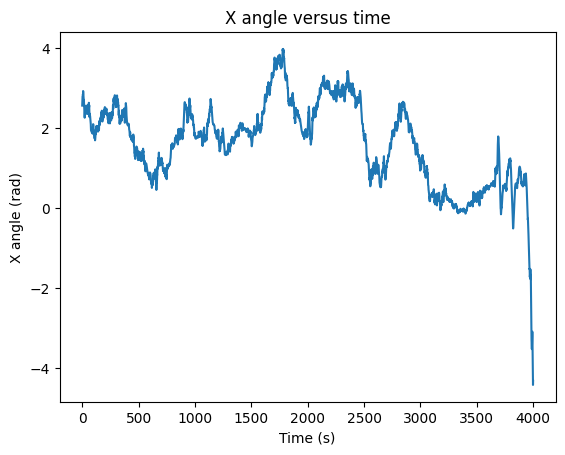

In [ ]:
# Plot x versus time
xs = df_aligned["x"]
ts = xs.index
plt.plot(ts, xs)
plt.xlabel("Time (s)")
plt.ylabel("X angle (deg)")
plt.title("X angle versus time")
plt.show()